In [5]:
import argparse
import matplotlib.pyplot as plt
import pandas
from sqlalchemy.future import select
from revolve2.core.database import open_database_sqlite
from revolve2.core.optimization.ea.openai_es import DbOpenaiESOptimizerIndividual

def save_csv(database: str, process_id: int) -> None:
    # open the database
    try:
        db = open_database_sqlite(database)
    except:
        print("no!")
        return
    # read the optimizer data into a pandas dataframe
    df = pandas.read_sql(
        select(DbOpenaiESOptimizerIndividual).filter(
            DbOpenaiESOptimizerIndividual.process_id == process_id
        ),
        db,
    )
    df.to_csv(f'{database}/data.csv', index=False)


In [6]:
########### save data as csv file

morphologies = ['spider6', 'spider10' , 'spider14', 'T6', 'T10', 'T14', 'snake6', 'snake10', 'snake14'] # 'gecko6', 'gecko10', 'gecko14', 

for morphologie in morphologies:
    for i in range(1, 11):
        database = f"data/openaiES/{morphologie}/database{i}"
        save_csv(database, 0)

OperationalError: (sqlite3.OperationalError) no such table: openaies_optimizer_individual
[SQL: SELECT openaies_optimizer_individual.process_id, openaies_optimizer_individual.gen_num, openaies_optimizer_individual.gen_index, openaies_optimizer_individual.individual, openaies_optimizer_individual.fitness 
FROM openaies_optimizer_individual 
WHERE openaies_optimizer_individual.process_id = ?]
[parameters: (0,)]
(Background on this error at: https://sqlalche.me/e/14/e3q8)

In [3]:
import pandas as pd
import seaborn as sns
import copy
import matplotlib.pyplot as plt

def replace_with_max(df: pd.DataFrame) -> pd.DataFrame:  
    max_so_far = -float('inf')
    for i, row in df.iterrows():
        max_so_far = max(max_so_far, row['fitness'])
        df.at[i, 'fitness'] = max_so_far
    return df

def append_df(df, experiment, morphologie):

    database = f"data/openaiES/{morphologie}/database{i}/data.csv"
    df_old = df
    df = pd.read_csv(database)
    df = df.groupby('gen_num').max() # aggregate over generations
    df['fitness'] = df['fitness']/30
    df["Experiment"] = experiment
    df["Morphologie"] = morphologie
    df = replace_with_max(df)
    if isinstance(df_old, pd.DataFrame):
        df = pd.concat([df, df_old])  # concat dataframes
        return df
    else: 
        return df
    
morphologies = ['spider6', 'spider10' , 'spider14', 'T6', 'T10', 'T14', 'snake6', 'snake10', 'snake14'] # 'gecko6', 'gecko10', 'gecko14',

df = None
for morphologie in morphologies:
    for i in range(1, 11):
        df = append_df(df, i, morphologie)


FileNotFoundError: [Errno 2] No such file or directory: 'data/openaiES/spider6/database10/data.csv'

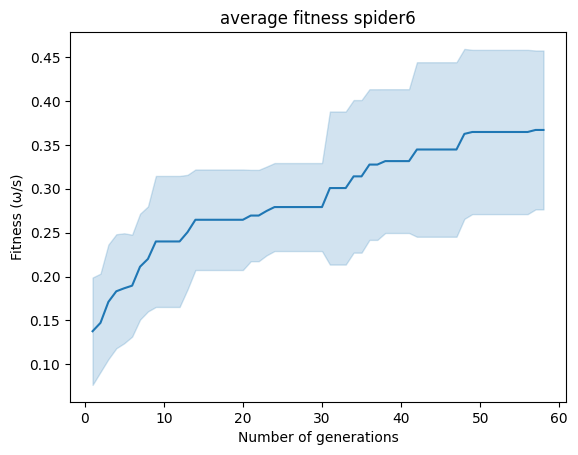

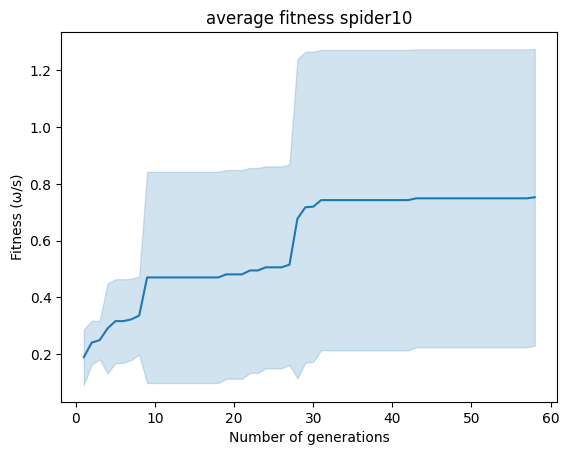

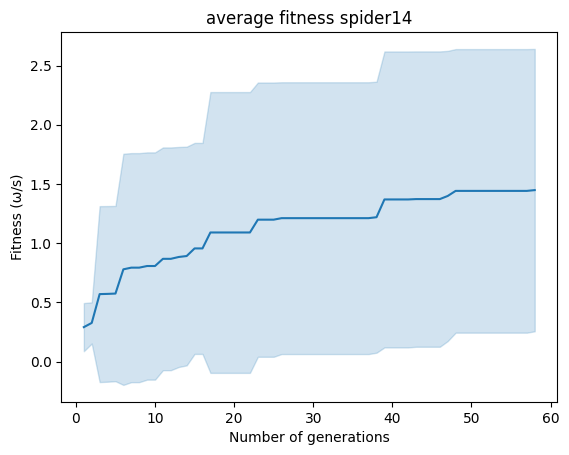

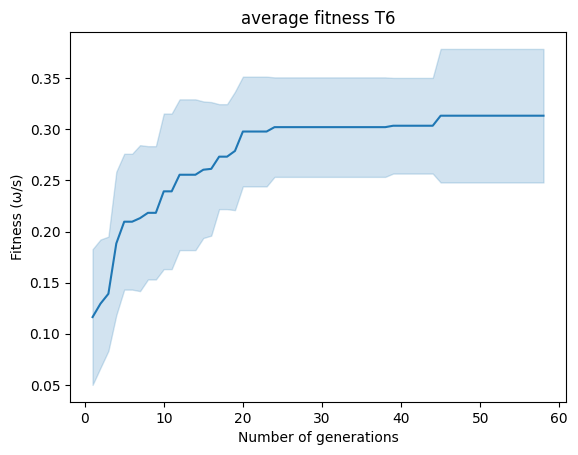

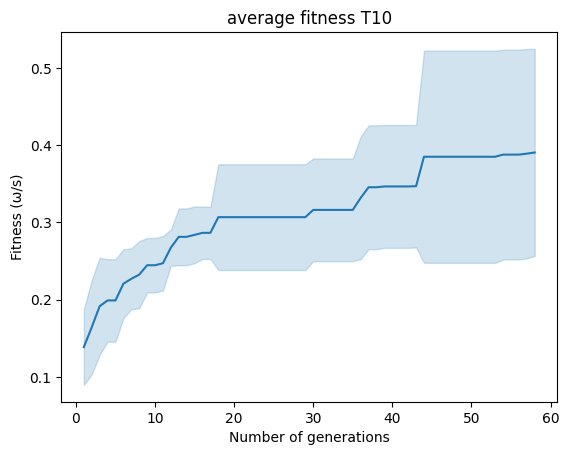

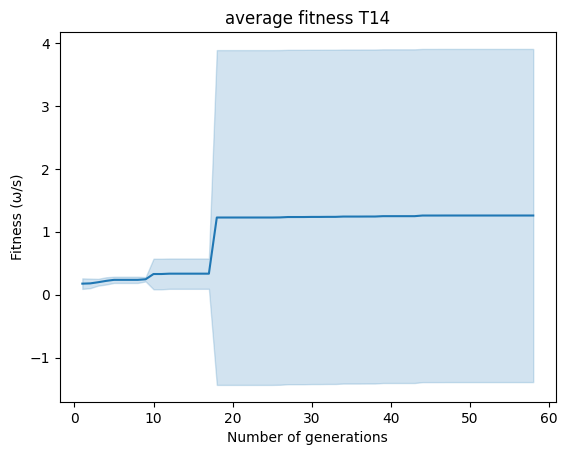

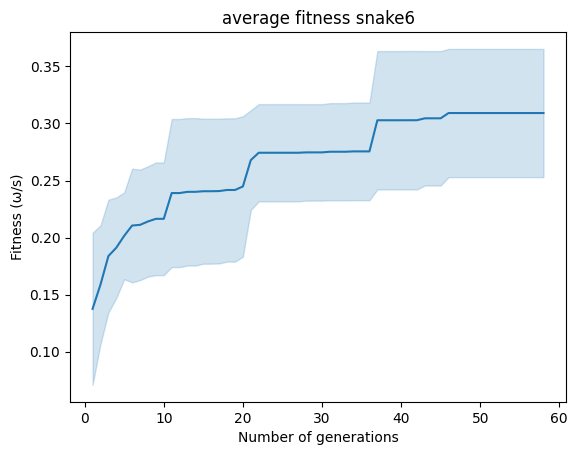

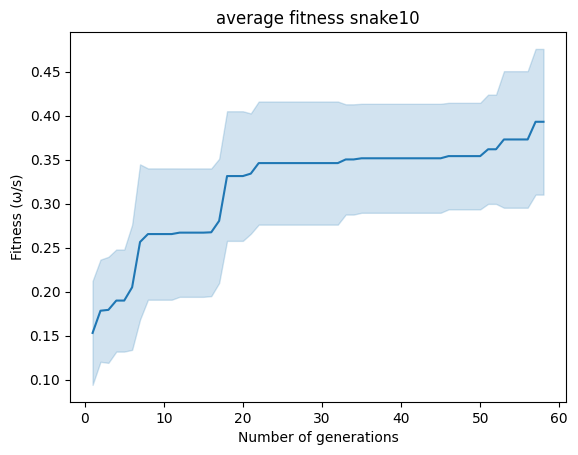

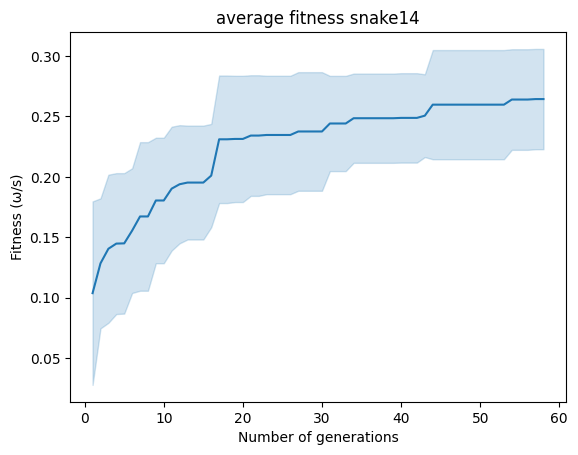

In [2]:
# plot fitness curves

morphologies = ['spider6', 'spider10' , 'spider14', 'T6', 'T10', 'T14', 'snake6', 'snake10', 'snake14'] # 'gecko6', 'gecko10', 'gecko14', 

for morphologie in morphologies:

    ax = sns.lineplot(data=df[df['Morphologie'] == morphologie], x="gen_num", y="fitness", estimator='mean', errorbar="sd")
    ax.set(xlabel='Number of generations',
       ylabel='Fitness (ω/s)',
       title= (f'average fitness {morphologie}'))
    #ax.set(ylim=(0, 32))
    fig = ax.get_figure()
    fig.savefig(f"dataanalysis/mean_fitness_rotation_{morphologie}.png")
    plt.show()

In [76]:
# translate to MBF
import pandas as pd
import seaborn as sns
import copy
import matplotlib.pyplot as plt

def replace_with_max(df: pd.DataFrame) -> pd.DataFrame:
    max_so_far = -float('inf')
    for i, row in df.iterrows():
        max_so_far = max(max_so_far, row['fitness'])
        df.at[i, 'fitness'] = max_so_far
    return df

def append_df(df, experiment, morphologie):

    database = f"data/openaiES/{morphologie}/database{i}/data.csv"
    df_old = df
    df = pd.read_csv(database)
    #df = df.groupby('gen_num').max() # aggregate over generations
    df = df[df['fitness'] == df['fitness'].max()]
    
    #df = df.loc[df["fitness"].idxmax()]
    #df = df.to_frame(name='fitness')
   
    df['fitness'] = df['fitness']/30
    df["Experiment"] = experiment
    df["Morphologie"] = morphologie
    #df = replace_with_max(df)
    #print(df)
    if isinstance(df_old, pd.DataFrame):
        df = pd.concat([df, df_old])  # concat dataframes
        return df
    else: 
        return df
    
morphologies = ['spider6', 'spider10' , 'spider14', 'T6', 'T10', 'T14', 'snake6', 'snake10', 'snake14'] # 'gecko6', 'gecko10', 'gecko14',

df_mbf = None
for morphologie in morphologies:
    for i in range(1, 10):
        df_mbf = append_df(df_mbf, i, morphologie)

In [84]:
df_mbf.head(5)

,process_id,gen_index,individual,fitness,Experiment,Morphologie,Size,Shape
gen_num,,,,,,,,
1,0,9,12,0.047866,9,snake14,14,snake
2,0,9,23,0.096797,9,snake14,14,snake
3,0,9,34,0.096797,9,snake14,14,snake
4,0,9,45,0.096797,9,snake14,14,snake
5,0,9,56,0.096797,9,snake14,14,snake


In [80]:
# average over size and shape
# add size and shape column
def add_shape_size(df):
    
    df['Size'] = "i" # initiazte size column
    for x in df['Morphologie']:
        if str("6") in str(x):
            df.loc[df['Morphologie'] == x,["Size"]] = '6'
        elif str("10") in str(x):
            df.loc[df['Morphologie'] == x,["Size"]] = '10'
        elif str("14") in str(x):
            df.loc[df['Morphologie'] == x,["Size"]] = '14'

    df['Shape'] = "i" # initiate shape column
    for x in df['Morphologie']:
        if str("snake") in str(x):
            df.loc[df['Morphologie'] == x,["Shape"]] = "snake"
        elif str("T") in str(x):
            df.loc[df['Morphologie'] == x,["Shape"]] = "T"
        elif str("gecko") in str(x):
            df.loc[df['Morphologie'] == x,["Shape"]] = "gecko"
        elif str("spider") in str(x):
            df.loc[df['Morphologie'] == x,["Shape"]] = "spider"
    return df

df_mbf = add_shape_size(df)




In [78]:
df_mbf['fitness'].aggregate('std')

1.0264000120893377

In [79]:
df_mbf['fitness'].aggregate('mean')

0.6106423383784754

In [83]:
# store mbf tables as csv file

df_morphologie = df_mbf.groupby(['Morphologie']).agg(['mean','var'])['fitness'] # group by morphologie and aggregate
df_size = df_mbf.groupby(['Size']).agg(['mean','var'])['fitness'] # group by size and aggregate
df_shape = df_mbf.groupby(['Shape']).agg(['mean','var'])['fitness'] # group by size and aggregate


df_morphologie.to_csv('dataanalysis/mbf_nes_rot_morphologie.csv')
df_size.to_csv('dataanalysis/mbf_nes_rot_size.csv')
df_shape.to_csv('dataanalysis/mbf_nes_rot_shape.csv')

C:\Users\marti\AppData\Local\Temp\ipykernel_11216\3757796334.py:1: FutureWarning: ['Size', 'Shape'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df_morphologie = df_mbf.groupby(['Morphologie']).agg(['mean','var'])['fitness'] # group by morphologie and aggregate
C:\Users\marti\AppData\Local\Temp\ipykernel_11216\3757796334.py:2: FutureWarning: ['Morphologie', 'Shape'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df_size = df_mbf.groupby(['Size']).agg(['mean','var'])['fitness'] # group by size and aggregate
C:\Users\marti\AppData\Local\Temp\ipykernel_11216\3757796334.py:3: FutureWarning: ['Morphologie', 'Size'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df_shape = df_mbf.groupb